An example program that shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. 

* To run this code, first you will need to install [OpenSlide](https://openslide.org/), the only non-Python dependency. 


* Tissue masks were produced for each slide using [ASAP](https://github.com/computationalpathologygroup/ASAP) and the instructions on the competition website. I did this in advance for you, so you wouldn't have to spend energy installing ASAP on OSX (it has a variety of dependencies). This way, you'll only need to install OpenSlide.


* OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom) you can use to view the tissue images (after installing open slide, clone that repo, `cd` into the examples, and run `python deepzoom_server.py`.


* You can find an example slide and tumor mask [here](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing).




In [1]:
import tensorflow as tf
tf.enable_eager_execution()

!apt-get install openslide-tools
!pip install openslide-python
!pip install opencv-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 8 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (154 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 110377 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack .

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
from PIL import Image
from skimage.color import rgb2gray
import cv2
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"
print(openslide_version)

3.4.1


In [3]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

['/device:GPU:0']

# Training

## Data preprocessing

In [6]:
## Download training data -- image and tumor mask
!gsutil cp  gs://terry-columbia/deep_learning_final_project/tumor_091_mask.tif tumor_091_mask.tif
!gsutil cp  gs://terry-columbia/deep_learning_final_project/tumor_091.tif tumor_091.tif

Copying gs://terry-columbia/deep_learning_final_project/tumor_091_mask.tif...
\ [1 files][ 14.7 MiB/ 14.7 MiB]                                                
Operation completed over 1 objects/14.7 MiB.                                     
Copying gs://terry-columbia/deep_learning_final_project/tumor_091.tif...
| [1 files][521.1 MiB/521.1 MiB]                                                
Operation completed over 1 objects/521.1 MiB.                                    


In [7]:
## This to remove data if you want to splice it at another size
!rm -r 'data'

rm: cannot remove 'data': No such file or directory


In [10]:
## Load in training image and mask using openslide
slide_path = 'tumor_091.tif'
tumor_mask_path = 'tumor_091_mask.tif'

slide = open_slide(slide_path)

print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))
tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]



Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [0]:
## Define a function to read the slide and convert it to a numpy array
## Numpy array has depth = 3, channels = RGB 

def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [0]:
# might be useful to add a method for reading masks?

def read_slide_mask(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im[:,:,0]

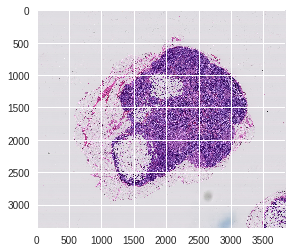

In [14]:
## Read training image at slide level 3
num_level = 4
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=num_level, 
                         width=slide.level_dimensions[num_level][0], 
                         height=slide.level_dimensions[num_level][1])

## Plot training image
plt.imshow(slide_image)

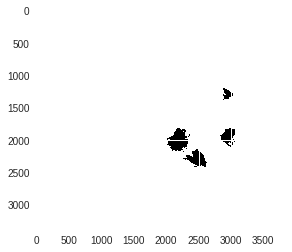

In [15]:
## Read the training mask at the same level (slide level 3)
## Any level below 3 causes memory overflow

mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=num_level, 
                        width=slide.level_dimensions[num_level][0], 
                        height=slide.level_dimensions[num_level][1])

## Convert the mask from RGB to a black/white binary
mask_image = mask_image[:,:,0]

# Plot training image masl
plt.imshow(mask_image)


In [0]:
## Downsampling/zoom example, no real use as of yet.

# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor
# Here, we're "aiming" for the top right yellow blob in the image above.

# region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
# plt.imshow(region)

In [16]:
## Determine the portions of the image that are tissue
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

tissue_pixels = list(find_tissue_pixels(slide_image))

percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

## Turn the tissue pixels into a mask
def apply_mask(im, mask, color= 1): #[255,0,0]):
#     masked = np.copy(im)
    masked = np.zeros((im.shape[0], im.shape[1]))
    for x,y in mask: masked[x][y] = color
    return masked

## Plot tissue regions
tissue_regions = apply_mask(slide_image, tissue_pixels)
# plt.imshow(tissue_regions)



3451212 tissue_pixels pixels (30.6 percent of the image)


In [0]:
## Define function to create directories to store slices of the training image
def initialize_directories(slide_path):
    BASE_DIR = os.getcwd()
    
    img_num = slide_path.split('_')[1].strip(".tif")

    # Create a folder for each image
    # Within that numbered image folder, create two other folders to hold the image slices 
    # that contain tumor cells and those that don't.
    
    DATA = 'data/'
    IMG_NUM_FOLDER = img_num + '/'
    TUMOR_FOLDER = 'tumor/'
    NO_TUMOR_FOLDER = 'no_tumor/'
    
    DATA_DIR = os.path.join(BASE_DIR, DATA)
    IMG_NUM_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER)
    TUMOR_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, TUMOR_FOLDER)
    NO_TUMOR_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, NO_TUMOR_FOLDER)
    
    if not os.path.exists(DATA_DIR):
        os.mkdir(DATA_DIR)
    if not os.path.exists(IMG_NUM_DIR):
        os.mkdir(IMG_NUM_DIR)
    if not os.path.exists(TUMOR_DIR):
        os.mkdir(TUMOR_DIR)
    if not os.path.exists(NO_TUMOR_DIR):
        os.mkdir(NO_TUMOR_DIR)
    
    # Return the locations of these folders for future use
    return DATA + IMG_NUM_FOLDER + TUMOR_FOLDER, DATA + IMG_NUM_FOLDER + NO_TUMOR_FOLDER

In [0]:
## Define a function to split the image into slices and place them in the proper folder
def split_image_and_mask(im, tumor_mask, tissue_mask,  num_pixels, level, slide_path):
    x,y = im.shape[0], im.shape[1]
    
    # Find the number of image slices that the original image will split into
    x_count, y_count = int(np.ceil(x / num_pixels)), int(np.ceil(y/num_pixels))

    tumor_folder, no_tumor_folder = initialize_directories(slide_path)
  

    try:
        for i in range(x_count):
            for j in range(y_count):
                im_slice = np.zeros((num_pixels, num_pixels, 3))
                tissue_mask_slice = np.zeros((num_pixels, num_pixels))
                tumor_mask_slice = np.zeros((num_pixels, num_pixels))

                # Name the image slice based on where it lies in the original image
                string_name = 'img_level%d_'%(level) + str(i * y_count + j)

                # Logic to handle end conditions
                if i == x_count-1:
                    ub_x = x
                    assign_x = x - (x_count-1)*num_pixels
                else:
                    ub_x = (i+1) * num_pixels
                    assign_x = num_pixels

                if j == y_count-1:
                    ub_y = y
                    assign_y = y - (y_count-1)*num_pixels
                else:
                    ub_y = (j+1) * num_pixels
                    assign_y = num_pixels       
                
                # Assign the pixels to the slice of the tissue mas
                tissue_mask_slice[0:assign_x, 0:assign_y] = tissue_mask[(i*num_pixels) :ub_x, (j * num_pixels) :ub_y]

                try:
                    # If 70% of the slice is tissue, process with classifying the slice
                    # (tumor/no tumor) and saving 
                    if np.mean(tissue_mask_slice) > 0.7:
                        im_slice[0:assign_x, 0:assign_y, :] = im[(i*num_pixels) :ub_x, (j * num_pixels) :ub_y, :]
                        tumor_mask_slice[0:assign_x, 0:assign_y] = tumor_mask[(i*num_pixels) :ub_x, (j * num_pixels) :ub_y]

                        if np.max(tumor_mask_slice) > 0:
                            im_file_name = tumor_folder + string_name + ".jpg" 
                        else:
                           im_file_name = no_tumor_folder + string_name + ".jpg"
                        
                        cv2.imwrite(im_file_name, im_slice)
                except Exception as oerr:
                    print('Error with saving:', oerr)
    except Exception as oerr:
        print('Error with slicing:', oerr)
                    

In [0]:
## Call the split function on the training data
## Break into 64 pixels (no real reason for this number)
num_pixels = 64
split_image_and_mask(slide_image, mask_image, tissue_regions, num_pixels, num_level, slide_path)

## Create pipeline for training data

In [20]:
## Give the labels a corresponding index
label_names = sorted(['tumor', 'no_tumor'])
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'no_tumor': 0, 'tumor': 1}

In [21]:
import random
import pathlib 

## Create a list of all the images to use in the tf.data pipeline
## This list is trimmed to have an equal amount of tumor/non_tumor images to help w training
## In future steps, I think we should use data augmentation to increase the number of tumor cells,
## not decrease the amount of non-tumor cells. 

img_num = slide_path.split('_')[1].strip(".tif")

# data_root = pathlib.Path('/content/data')
# all_image_paths = list(data_root.glob('*'))
# all_image_paths = [str(path) for path in all_image_paths]
# random.shuffle(all_image_paths)

data_root_tumor        = pathlib.Path('data/'+ img_num + '/tumor')
all_image_paths_tumor = list(data_root_tumor.glob('*'))
num_tumor_images = len(all_image_paths_tumor)

data_root_notumor       = pathlib.Path('data/'+ img_num + '/no_tumor')
all_image_paths_notumor = list(data_root_notumor.glob('*'))
random.shuffle(all_image_paths_notumor)
all_image_paths_notumor = all_image_paths_notumor[0:num_tumor_images]

print(len(all_image_paths_tumor), len(all_image_paths_notumor))

# Create a list of strings containing the path of every image we will put in the pipeline, shuffle
all_image_paths = [str(path) for path in all_image_paths_tumor + all_image_paths_notumor]
random.shuffle(all_image_paths)


83 83


In [22]:
## Find the corresponding indices of these images
data_root = pathlib.Path('data')
label_names = sorted(item.name for item in data_root.glob(img_num+'/*') if item.is_dir())
label_to_index = dict((name, index) for index,name in enumerate(label_names))
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])
print(len(all_image_labels))

First 10 labels indices:  [1, 1, 0, 1, 0, 1, 1, 1, 0, 1]
166


In [0]:
## Helper functions for the pipeline (resize to 128x128)
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [128, 128])
    image /= 255.0  # normalize to [0,1] range

    return image

def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

In [24]:
## Create the tf dataset
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
print('shape: ', repr(path_ds.output_shapes))
print('type: ', path_ds.output_types)
print()
print(path_ds)

shape:  TensorShape([])
type:  <dtype: 'string'>

<TensorSliceDataset shapes: (), types: tf.string>


In [0]:
## Create a pipeline of helper-functions for images loaded into the dataset
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=8)

In [26]:
## Convert image labels to their indices for the dataset
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))
for label in label_ds.take(10):
    print(label_names[label.numpy()])

tumor
tumor
no_tumor
tumor
no_tumor
tumor
tumor
tumor
no_tumor
tumor


In [0]:
## Zip up the images and label indices
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [28]:
print('image shape: ', image_label_ds.output_shapes[0])
print('label shape: ', image_label_ds.output_shapes[1])
print('types: ', image_label_ds.output_types)
print()
print(image_label_ds)

image shape:  (128, 128, 3)
label shape:  ()
types:  (tf.float32, tf.int64)

<ZipDataset shapes: ((128, 128, 3), ()), types: (tf.float32, tf.int64)>


In [29]:
## Set parameters for the dataset
BATCH_SIZE = 32

# Setting a shuffle buffer size larger than the dataset ensures that the data is completely shuffled.
ds = image_label_ds.repeat()
ds = ds.shuffle(buffer_size=4000) 
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetches batches, asynchronously while the model is training.
ds = ds.prefetch(1)
ds

<PrefetchDataset shapes: ((?, 128, 128, 3), (?,)), types: (tf.float32, tf.int64)>

## Train a model on imagenet and level 3 imagery only

In [31]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

## Create model in Keras, upload imagenet network + weights as convolution base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(128, 128, 3))
conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.summary()
# model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                262176    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 14,976,930
Trainable params: 262,242
Non-trainable params: 14,714,688
_________________________________________________________________


In [32]:
print(model.output)

DeferredTensor('None', shape=(?, 2), dtype=float32)


In [0]:
## Compile the model
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['acc'])

In [35]:
## Train the model
history = model.fit(ds, epochs=10, steps_per_epoch=int(np.ceil(len(all_image_paths)/BATCH_SIZE)))

Epoch 1/10
6/6 [==============================] - 5s 787ms/step - loss: 0.3437 - acc: 0.8802
Epoch 2/10
6/6 [==============================] - 2s 336ms/step - loss: 0.3112 - acc: 0.9115
Epoch 3/10
6/6 [==============================] - 2s 334ms/step - loss: 0.2884 - acc: 0.9167
Epoch 4/10
6/6 [==============================] - 2s 333ms/step - loss: 0.2864 - acc: 0.8646
Epoch 5/10
6/6 [==============================] - 2s 333ms/step - loss: 0.2333 - acc: 0.9583
Epoch 6/10
6/6 [==============================] - 2s 334ms/step - loss: 0.2608 - acc: 0.8958
Epoch 7/10
6/6 [==============================] - 2s 336ms/step - loss: 0.2416 - acc: 0.8750
Epoch 8/10
6/6 [==============================] - 2s 335ms/step - loss: 0.2387 - acc: 0.9271
Epoch 9/10
6/6 [==============================] - 2s 334ms/step - loss: 0.2581 - acc: 0.8594
Epoch 10/10
6/6 [==============================] - 2s 334ms/step - loss: 0.1906 - acc: 0.9583


{'loss': [0.3437489718198776, 0.31120029588540393, 0.2883632332086563, 0.2863785574833552, 0.23331041385730109, 0.26081250607967377, 0.2416329731543859, 0.23867923766374588, 0.25813278555870056, 0.19057330985864004], 'acc': [0.8802083333333334, 0.9114583333333334, 0.9166666666666666, 0.8645833333333334, 0.9583333333333334, 0.8958333333333334, 0.875, 0.9270833333333334, 0.859375, 0.9583333333333334]}


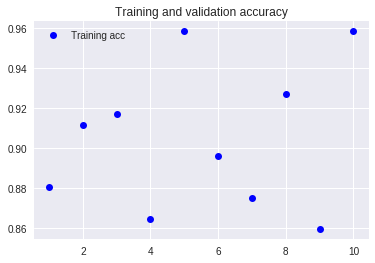

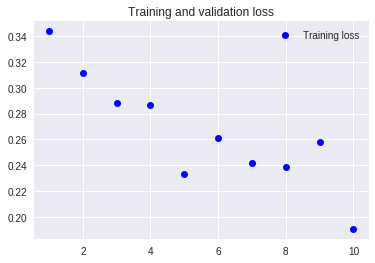

In [36]:
## Plot results
import matplotlib.pyplot as plt

print(history.history)

acc = history.history['acc']
loss = history.history['loss']
# val_acc = history.history['val_loss']
# val_loss = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b-', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b-', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Testing

## Data preprocessing

In [37]:
## Load in testing data
!gsutil cp  gs://terry-columbia/deep_learning_final_project/tumor_110_mask.tif tumor_110_mask.tif
!gsutil cp  gs://terry-columbia/deep_learning_final_project/tumor_110.tif tumor_110.tif

Copying gs://terry-columbia/deep_learning_final_project/tumor_110_mask.tif...
- [1 files][ 31.4 MiB/ 31.4 MiB]                                                
Operation completed over 1 objects/31.4 MiB.                                     
Copying gs://terry-columbia/deep_learning_final_project/tumor_110.tif...
\ [1 files][  1.4 GiB/  1.4 GiB]   45.0 MiB/s                                   
Operation completed over 1 objects/1.4 GiB.                                      


In [0]:
slide_path = 'tumor_110.tif'
tumor_mask_path = 'tumor_110_mask.tif'

slide = open_slide(slide_path)
tumor_mask = open_slide(tumor_mask_path)

In [0]:
## Read in slide and tumor mask at a level 3
level_num = 3

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level_num, 
                         width=slide.level_dimensions[level_num][0], 
                         height=slide.level_dimensions[level_num][1])
# plt.imshow(slide_image)
# Example: read the mask at the same zoom
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level_num, 
                        width=slide.level_dimensions[level_num][0], 
                        height=slide.level_dimensions[level_num][1])

mask_image = mask_image[:,:,0]

# plt.imshow(mask_image)
# print(np.max(mask_image))


In [40]:
print(mask_image.shape)

(8960, 11776)


In [0]:
## Find regions that are tissue
tissue_pixels = list(find_tissue_pixels(slide_image))
tissue_regions = apply_mask(slide_image, tissue_pixels)

In [42]:
print(tissue_regions.shape)
print(np.max(tissue_regions))

(8960, 11776)
1.0


In [0]:
## Create directories for testing
## NOTE: These are different than the training directories
## I created two -- one for all slices of the original testing image, and the 
## second for the image slices that contained > 0.7 tissue. Idk which one we will
## end up testing on

def initialize_directories_test(slide_path):
    BASE_DIR = os.getcwd()
    
    img_num = slide_path.split('_')[1].strip(".tif")

    
    DATA = 'data/'
    IMG_NUM_FOLDER = img_num + '/'
    TISSUE_FOLDER = 'tissue_only/'
    ALL_FOLDER    = 'all/'
    
    
    DATA_DIR = os.path.join(BASE_DIR, DATA)
    IMG_NUM_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER)
    TISSUE_DIR  = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, TISSUE_FOLDER)
    ALL_DIR     = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, ALL_FOLDER)
    
    if not os.path.exists(DATA_DIR):
        os.mkdir(DATA_DIR)
    if not os.path.exists(IMG_NUM_DIR):
        os.mkdir(IMG_NUM_DIR)
    if not os.path.exists(TISSUE_DIR):
        os.mkdir(TISSUE_DIR)
    if not os.path.exists(ALL_DIR):
        os.mkdir(ALL_DIR)
    
    
    return DATA + IMG_NUM_FOLDER + TISSUE_FOLDER, DATA + IMG_NUM_FOLDER + ALL_FOLDER

In [0]:
## Function to split and save test images, slightly different than analogous
## function for training
def split_image_test(im, tissue_mask, num_pixels, level_num, slide_path):
    x,y = im.shape[0], im.shape[1]
    x_count, y_count = int(np.ceil(x / num_pixels)), int(np.ceil(y/num_pixels))

    tissue_folder, all_folder = initialize_directories_test(slide_path)
    

    try:
        for i in range(x_count):
            for j in range(y_count):
                im_slice = np.zeros((num_pixels, num_pixels, 3))
                im_tissue_slice = np.zeros((num_pixels, num_pixels, 3))
                tissue_mask_slice = np.zeros((num_pixels, num_pixels))
                
                string_name = 'img_level%d_'%(level_num) + str(i * y_count + j)

                if i == x_count-1:
                    ub_x = x
                    assign_x = x - (x_count-1)*num_pixels
                else:
                    ub_x = (i+1) * num_pixels
                    assign_x = num_pixels

                if j == y_count-1:
                    ub_y = y
                    assign_y = y - (y_count-1)*num_pixels
                else:
                    ub_y = (j+1) * num_pixels
                    assign_y = num_pixels       

                tissue_mask_slice[0:assign_x, 0:assign_y] = tissue_mask[(i*num_pixels) :ub_x, (j * num_pixels) :ub_y]

                try:
                    if np.mean(tissue_mask_slice) > 0.7:
                        im_tissue_slice[0:assign_x, 0:assign_y, :] = im[(i*num_pixels) :ub_x, (j * num_pixels) :ub_y, :]
                        im_file_name_tissue = tissue_folder + string_name + ".jpg"
                        cv2.imwrite(im_file_name_tissue, im_tissue_slice)
                    
                    
                    im_slice[0:assign_x, 0:assign_y, :] = im[(i*num_pixels) :ub_x, (j * num_pixels) :ub_y, :]
                    im_file_name_all = all_folder + string_name + ".jpg"
                    cv2.imwrite(im_file_name_all, im_slice)
                     
                except Exception as oerr:
                    print('Error with saving:', oerr)
    
    except Exception as oerr:
        print('Error with slicing:', oerr)  

In [0]:
# In case you need to delete the saved images and try again 
# !rm -r 'data/110'

In [0]:
## Generate new test image and mask slices
num_pixels = 64
level_num = 3

split_image_test(slide_image, tissue_regions, num_pixels, level_num, slide_path)

## Create pipeline for testing data

In [46]:
## Create list of strings for a tf dataset
img_num = slide_path.split('_')[1].strip(".tif")
img_test_folder = 'tissue_only'
 
data_root = pathlib.Path('data/'+ img_num + '/' + img_test_folder)
all_image_paths = list(data_root.glob('*'))
all_image_paths = [str(path) for path in all_image_paths]
# random.shuffle(all_image_paths)
print(len(all_image_paths))

7616


In [47]:
## Create the tf dataset with the testing image paths
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
print('shape: ', repr(path_ds.output_shapes))
print('type: ', path_ds.output_types)
print()
print(path_ds.output_shapes)

shape:  TensorShape([])
type:  <dtype: 'string'>

()


In [0]:
# Map the dataset to help functions
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=8)

In [49]:
## Zip up the image dataset (must be a tuple!)
image_test_ds = tf.data.Dataset.zip((image_ds,))
print('image shape: ', image_test_ds.output_shapes)
print('types: ', image_test_ds.output_types)
print()
print(image_test_ds)

image shape:  (TensorShape([Dimension(128), Dimension(128), Dimension(3)]),)
types:  (tf.float32,)

<ZipDataset shapes: ((128, 128, 3),), types: (tf.float32,)>


In [50]:
## Dataset parameters
BATCH_SIZE = 32

# Setting a shuffle buffer size larger than the dataset ensures that the data is completely shuffled.
ds = image_test_ds.repeat()
ds = ds.batch(BATCH_SIZE, drop_remainder = True)
# `prefetch` lets the dataset fetches batches, asynchronously while the model is training.
ds = ds.prefetch(1)
ds

<PrefetchDataset shapes: ((32, 128, 128, 3),), types: (tf.float32,)>

## Model prediction and results visualization

In [0]:
## Predict tumor presence on test data
test = model.predict(ds, steps = int(np.ceil(len(all_image_paths)/BATCH_SIZE )))

In [52]:
test = test[0:len(all_image_paths), :]
print(len(test))

7616


In [53]:
## Create mask containing test predictions
img_num = np.zeros(len(all_image_paths))
for i in range(len(all_image_paths)):
    img_num[i] = int(all_image_paths[i].strip('.jpg').split('/')[-1].split('_')[-1])
    
depth, width = int(np.ceil(slide_image.shape[0]/num_pixels)), int(np.ceil(slide_image.shape[1]/num_pixels))

print(depth, width)

predictions = np.zeros((depth, width))
conf_threshold = 0.7

for i in range(len(test)):
    y = int(img_num[i] // width)
    x = int(np.mod(img_num[i], width))
    predictions[y,x] = int(test[i][1] > conf_threshold)


140 184


Text(0.5,1,'Actual Tumor Mask')

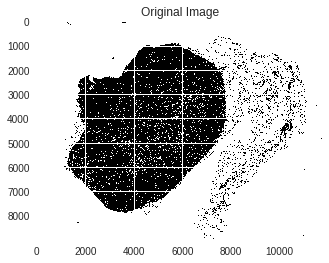

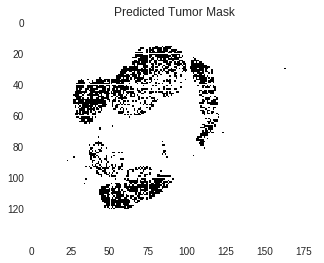

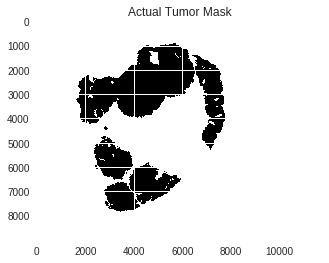

In [54]:
## Plot original image, prediction tumor mask, and actual tumor mask

fig1, ax1 = plt.subplots()
plt.imshow(tissue_regions)
ax1.set_title("Original Image")

fig2, ax2 = plt.subplots()
plt.imshow(predictions)
ax2.set_title("Predicted Tumor Mask")

fig3, ax3 = plt.subplots()
plt.imshow(mask_image)
ax3.set_title("Actual Tumor Mask")

# Evaluation

In [55]:
!pip install sklearn

In [0]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score
import pandas as pd

In [0]:
def heatmap_evaluation(predictions, tissue_regions, mask_image):
  
  # we only need to evaluate on areas which are tissue.
  # correct non tumor prediction count would be higher if we get credit for 
  # predicting gray areas aren't tumors
  
  # find out the correct amount to scale predictions to match image
  scale = int(mask_image.shape[0]/predictions.shape[0])
  
  # create scaled prediction matix
  predictions_scaled = np.kron(predictions, np.ones((scale, scale)))
  
  # reshape everything to a 1D vector for easy computation
  predictions_scaled = predictions_scaled.reshape(-1)
  mask_image = mask_image.reshape(-1)
  tissue_regions = tissue_regions.reshape(-1)
  
  # only include entries that have tissue 
  predictions_scaled = predictions_scaled[tissue_regions == 1]
  mask_image = mask_image[tissue_regions == 1]
  
  # evaluate
  p = precision_score(mask_image, predictions_scaled)
  print('Precision:', p)
  r = recall_score(mask_image, predictions_scaled)
  print('Recall:', r)
  f = f1_score(mask_image, predictions_scaled)
  print('F1:', f)
  cm = confusion_matrix(mask_image, predictions_scaled)
  df_cm = pd.DataFrame(cm,columns = ['Predicted 0', 'Predicted 1'])
  df_cm.index = ['Reality 0', 'Reality 1']
  print('Confusion Matrix:')
  df_cm = pd.DataFrame(cm,columns = ['Predicted 0', 'Predicted 1'])
  df_cm.index = ['Reality 0', 'Reality 1']
  print(df_cm)
  df_cm_percent = df_cm
  df_cm_percent['Predicted 0'] = 100*df_cm_percent['Predicted 0']/len(mask_image)
  df_cm_percent['Predicted 1'] = 100*df_cm_percent['Predicted 1']/len(mask_image)
  print(df_cm_percent)
  


In [58]:
heatmap_evaluation(predictions, tissue_regions, mask_image)

Precision: 0.9663316711593811
Recall: 0.5217751416565238
F1: 0.6776500722448443
Confusion Matrix:
           Predicted 0  Predicted 1
Reality 0     16196579       283997
Reality 1      7470801      8151141
           Predicted 0  Predicted 1
Reality 0    50.452675     0.884656
Reality 1    23.271698    25.390971
